# **Zero-Loss Peak Subtraction with Neural Networks**

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LHCfitNikhef/CBL-ML/blob/tutorial/Tutorial/EELS_tutorial.ipynb)

## Loading the data

First of all, let us install and import all the required modules

In [1]:
!pip install ncempy

In [2]:
from ncempy.io import dm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import imageClass as EELSImage
import trainZLP as ZLPnn
#from trainZLP import train_nn_scaled

In this tutorial, we will study.....

The spectral image can be imported with the lines below

In [3]:
path_to_dm4 = 'area03-eels-SI-aligned.dm4'
im = EELSImage.Spectral_image.load_data(path_to_dm4)

## Plotting the data

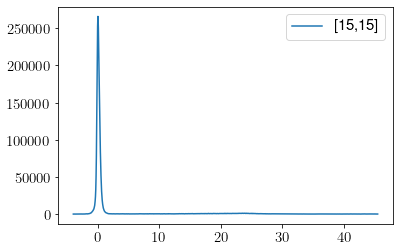

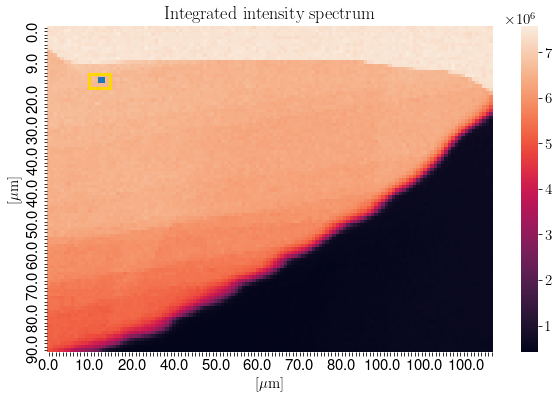

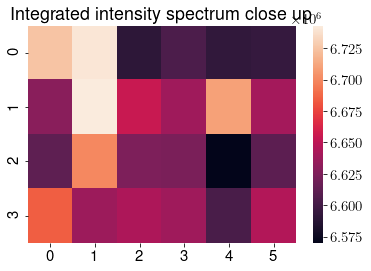

In [4]:
full_width, full_height = im.image_shape[1], im.image_shape[0]
loc_x, loc_y = int(0.12 * full_width), int(0.17 * full_height)
spectrum = im.plot_spectrum(loc_y, loc_x)

xmin, width = int(0.10 * full_width), int(0.05 * full_width)
ymin, height = int(0.15 * full_height), int(0.05 * full_height)

window = np.array([[xmin, width], [ymin, height]])
im.show_image(selection = window, pixel_highlight = [loc_x, loc_y])

## Smoothing

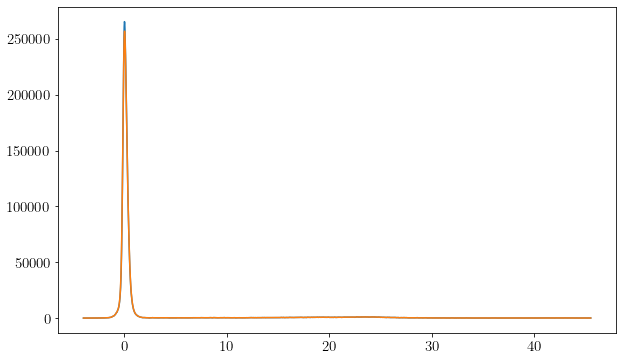

In [5]:
data_zoomed_concat = np.reshape(im.data_zoomed, (-1, im.l))
data_smooth = ZLPnn.smooth(data_zoomed_concat, window_len = 10)

plt.figure(figsize=(10,6))
plt.plot(im.deltaE, im.data_zoomed[-1, -2, :])
plt.plot(im.deltaE, data_smooth[-2,:])
plt.show()

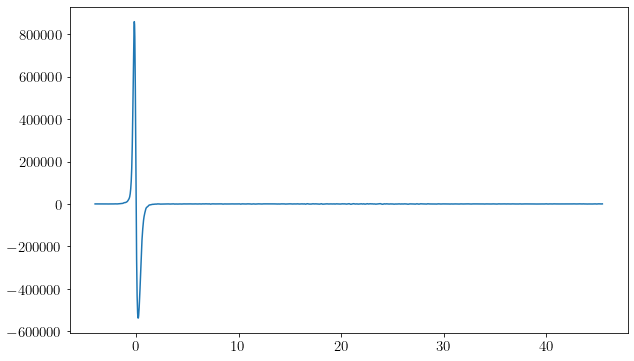

In [6]:
def der_spect(image, spectrum):
    dx = image.ddeltaE
    der_spectrum = (spectrum[:,1:]-spectrum[:,:-1])/dx
    return der_spectrum

der = der_spect(im, data_smooth)
der_smooth = ZLPnn.smooth(der, window_len = 10)

plt.figure(figsize=(10,6))
plt.plot(im.deltaE[:-1], der_smooth[-1,:])
plt.show()

## Finding $dE_1$ and $dE_2$

In [7]:
data_avg = np.average(data_smooth, axis=0)
der_avg = np.average(der, axis=0)

dE1 = ZLPnn.find_dE1(im, der_avg, data_avg, fct=0.7)

times_dE1 = 3
min_dE2 = im.deltaE.max() - im.ddeltaE*im.l*0.05 # discuss with Isabel
dE2 = np.minimum(dE1 * times_dE1, min_dE2) 

In [11]:
select1 = len(im.deltaE[im.deltaE<dE1]) # discuss with Isabel: not symmetric
select2 = len(im.deltaE[im.deltaE>dE2])

#discuss with Isabel
# pseudo_x = np.ones(select1 + select2)
# pseudo_x[:select1] = deltaE_scaled[:select1]
# pseudo_x[-select2:] = deltaE_scaled[-select2:]

## Rescaling the training data

In [12]:
def rescale(data, mean, std):
    return (data - mean) / std

deltaE_scaled = rescale(im.deltaE[:select1], np.mean(im.deltaE[:select1]), np.std(im.deltaE[:select1]))


# def find_scale_param(inp, min_out = 0.1, max_out=0.9):
#     a = (max_out - min_out)/(inp.max()- inp.min())
#     b = min_out - a * inp.min()
#     return [a, b]

# def scale(inp, ab):
#     return inp * ab[0] + ab[1]


# ab_deltaE = find_scale_param(im.deltaE)
# deltaE_scaled = scale(im.deltaE, ab_deltaE)


epsilon = 1e-3
data_zoomed_concat[data_zoomed_concat < 0] = epsilon

ci_low = np.nanpercentile(np.log(data_zoomed_concat), 16, axis=0)
ci_high = np.nanpercentile(np.log(data_zoomed_concat), 84, axis=0)
sigma = np.absolute(ci_high - ci_low)

Discuss with Isabel: rescale before or after applying dE cuts?

## Constructing the Neural Network

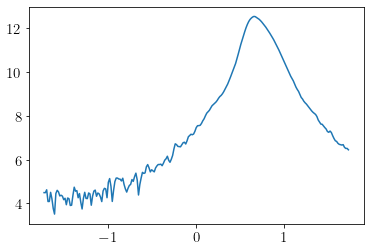

2021-06-01 12:55:22.531705 Replica 0, Epoch 1, Training loss 0.9632577909777934
2021-06-01 12:55:26.682085 Replica 0, Epoch 5000, Training loss 0.0017190946753256897
2021-06-01 12:55:30.912175 Replica 0, Epoch 10000, Training loss 0.0015933293461870299
2021-06-01 12:55:35.312277 Replica 0, Epoch 15000, Training loss 0.0010362867563464527
2021-06-01 12:55:39.718965 Replica 0, Epoch 20000, Training loss 0.0009269742912181834
2021-06-01 12:55:43.999792 Replica 0, Epoch 25000, Training loss 0.0007912282551184036
2021-06-01 12:55:48.615877 Replica 0, Epoch 30000, Training loss 0.0007519032740094985
2021-06-01 12:55:53.112551 Replica 0, Epoch 35000, Training loss 0.0006907058342496203
2021-06-01 12:55:57.374756 Replica 0, Epoch 40000, Training loss 0.0006589262296724162
2021-06-01 12:56:01.818920 Replica 0, Epoch 45000, Training loss 0.0006292247037319485
2021-06-01 12:56:06.585214 Replica 0, Epoch 50000, Training loss 0.0006123825318803269


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import datetime

class MLP(nn.Module):

    def __init__(self, num_inputs, num_outputs):
        super().__init__()
        self.linear1 = nn.Linear(num_inputs, 10)
        self.linear2 = nn.Linear(10, 15)
        self.linear3 = nn.Linear(15, 5)
        self.output = nn.Linear(5, num_outputs)
        self.tanh = nn.Tanh()
        #self.relu = nn.ReLU()

    def forward(self, x):
        x = self.linear1(x)
        x = self.tanh(x)
        x = self.linear2(x)
        x = self.tanh(x)
        x = self.linear3(x)
        x = self.tanh(x)
        x = self.output(x)
        return x
    
def loss_fn(output, target, error):
    loss = torch.sum(torch.square((output - target)/error))
    return loss

def weight_reset(m):
    if isinstance(m, nn.Linear):
        m.reset_parameters()

def training_loop(n_rep, n_epochs, optimizer, model, loss_fn):
    
    data_x = deltaE_scaled[:select1]
    data_x = torch.tensor(data_x).unsqueeze(-1) 
    
    for rep in range(n_rep):
        
        model.apply(weight_reset)
        
        data_y = np.log(data_zoomed_concat[rep][:select1])
        #data_y = data_zoomed_concat[n_rep][:select1]
        
        plt.plot(data_x, data_y)
        plt.show()
        
        data_y = torch.tensor(data_y).unsqueeze(-1)

        unc_y = im.data_unc[:select1]
        unc_y = torch.tensor(unc_y).unsqueeze(-1)
        
        for epoch in range(1, n_epochs + 1):
            
            loss_train = 0.0
            
            model_output = model(data_x.float())
            
            loss = loss_fn(model_output, data_y, unc_y)
            
            optimizer.zero_grad()
            
            loss.backward()
            
            optimizer.step()
            
            loss_train += loss.item()

            if epoch == 1 or epoch % 5000 == 0:
                print('{} Replica {}, Epoch {}, Training loss {}'.format(datetime.datetime.now(), rep, epoch, loss_train))
        
        torch.save(model.state_dict(), './models/trained_nn_rep_{}.pt'.format(rep))

n_rep = im.data_zoomed.shape[0] * im.data_zoomed.shape[1]
n_epochs = 50000
model = MLP(num_inputs=1, num_outputs=1)
optimizer = optim.Adam(model.parameters(), lr=1e-2)                
                
training_loop(
    n_rep = 1,
    n_epochs = n_epochs,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn
)

Play with different optimizers/architectures/learning rates

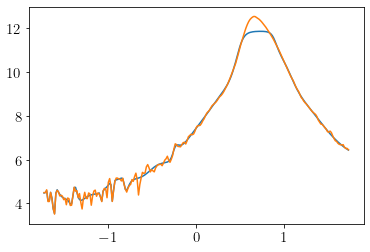

In [14]:
network_path = './models/trained_nn_rep_0.pt'
model.load_state_dict(torch.load(network_path))

data_x = deltaE_scaled[:select1]
data_x = torch.tensor(data_x).unsqueeze(-1)

model_pred = model.forward(data_x.float())
model_pred = model_pred.detach().numpy()

plt.plot(deltaE_scaled[:select1], model_pred)
plt.plot(deltaE_scaled[:select1], np.log(data_zoomed_concat[0][:select1]))
plt.show()

## Training report

Plot of loss
validation set
adding dE2


## Evaluating the trained models

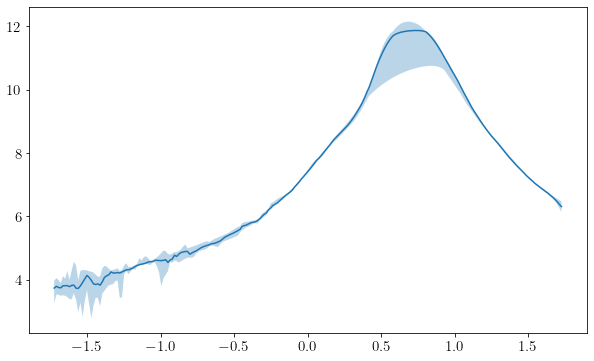

In [15]:
pred = []

for rep in range(6):
    network_path = './models/trained_nn_rep_{}.pt'.format(rep)
    model.load_state_dict(torch.load(network_path))
    
    model_pred = model.forward(data_x.float())
    model_pred = model_pred.detach().numpy()
    pred.append(model_pred[:,0])

pred = np.array(pred)
pred_median = np.median(pred, axis=0)
cl_low = np.nanpercentile(pred, 16, axis=0)
cl_high = np.nanpercentile(pred, 84, axis=0)

plt.figure(figsize=(10, 6))
ax = plt.subplot(111)
plt.plot(deltaE_scaled[:select1], pred_median)
ax.fill_between(deltaE_scaled[:select1], cl_low, cl_high, alpha = 0.3)
plt.show()

Discuss with Isabel: pretrained models

## ZLP subtraction

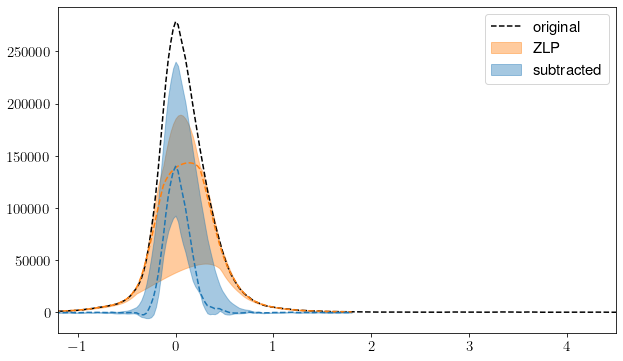

In [42]:
plt.figure(figsize=(10,6))
plt.plot(im.deltaE, data_zoomed_concat[0], linestyle='dashed', label='original', color='k')
plt.fill_between(im.deltaE[:select1], np.exp(cl_low), np.exp(cl_high), alpha = 0.4, label='ZLP', color='C1')
plt.plot(im.deltaE[:select1], np.exp(pred_median), linestyle = 'dashed', color='C1')
plt.plot(im.deltaE[:select1], data_zoomed_concat[0][:select1]-np.exp(pred_median), linestyle='dashed')
plt.fill_between(im.deltaE[:select1], data_zoomed_concat[0][:select1] - np.exp(cl_low), data_zoomed_concat[0][:select1] - np.exp(cl_high), alpha = 0.4, label='subtracted', color='C0')
plt.xlim(-1.2, 4.5)
plt.legend()
plt.show()

## Bandgap fit